Na podstwie ostatnich 5 przewidzieć kolejną jedna -- wejsscie to deltta t i zmiana kursu



Dane zrobic w fromie 5 danych i wynik , potemm je poshuflowac
wyrzucic zmiany dluzsze niz dzien
mozna zsporbowac dane gdzie nic sie nie zmienilo tez wyrzucic 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path='../data/KGHM_clear.csv'
df=pd.read_pickle(path)

In [3]:
LEARN_SAMPLE_SIZE=5

In [4]:
df.head()

,Name,Date,Open,High,Low,Close,Volume,TimeDelta,CoursChange,LowHighDiff,OpenCloseDiff
0,KGHM,2000-11-17 10:00:24,26.3,26.3,26.3,26.3,10840,0.0,NaN,0.0,0.0
1,KGHM,2000-11-17 10:00:25,26.3,26.3,26.3,26.3,1035,1.0,0.0,0.0,0.0
2,KGHM,2000-11-17 10:00:26,26.3,26.3,26.3,26.3,57,1.0,0.0,0.0,0.0
3,KGHM,2000-11-17 10:03:29,26.3,26.3,26.3,26.3,20288,183.0,0.0,0.0,0.0
4,KGHM,2000-11-17 10:09:28,26.2,26.2,26.2,26.2,9,359.0,-0.1,0.0,0.0


In [5]:
df=df[:100000]

In [6]:
df.drop(columns=['Name','Open','High','Low','Volume','LowHighDiff','OpenCloseDiff'],inplace=True)

In [7]:
df['day']=df['Date'].dt.strftime('%m/%d/%Y')

# Grupowanie po dniach

In [8]:
gb=df.groupby(df.day)

In [9]:
df_group_by_day_list=[gb.get_group(x).copy() for x in gb.groups]

In [10]:
for i in df_group_by_day_list:
    i.reset_index

In [11]:
df_group_by_day_list[0]

,Date,Close,TimeDelta,CoursChange,day
7122,2001-01-02 10:00:05,25.2,323402.0,-0.6,01/02/2001
7123,2001-01-02 10:00:08,25.2,3.0,0.0,01/02/2001
7124,2001-01-02 10:00:09,25.2,1.0,0.0,01/02/2001
7125,2001-01-02 10:00:10,25.2,1.0,0.0,01/02/2001
7126,2001-01-02 10:00:47,25.2,37.0,0.0,01/02/2001
7127,2001-01-02 10:03:56,25.2,189.0,0.0,01/02/2001
7128,2001-01-02 10:04:18,25.2,22.0,0.0,01/02/2001
7129,2001-01-02 10:06:35,25.1,137.0,-0.1,01/02/2001
7130,2001-01-02 10:06:40,25.1,5.0,0.0,01/02/2001
7131,2001-01-02 10:07:44,25.1,64.0,0.0,01/02/2001


# Dla każdego dnia możemy przeprowadzić osobne operacje

In [12]:
def prepare_day(df_group_by_day_list,learn_sample_size=5,predict_next=True):
    
    if predict_next:
        predict_n_steps_future=1
    else:
        predict_n_steps_future=0
        raise ValueError("Predicting long then next doesnt work yet") 
    for i,df_group in enumerate(df_group_by_day_list):
        #resetowanie indeksow
        
        
        #dodawanie wczesniejszych wartosci pomiarow
        for j in range(1,learn_sample_size):
            df_group_by_day_list[i]['Close_-'+str(j)]=df_group_by_day_list[i].loc[:,('Close')].shift(j)
            df_group_by_day_list[i]['TimeDelta_-'+str(j)]=df_group_by_day_list[i].TimeDelta.shift(j)
        
        #tworzenie wynikow
        df_group_by_day_list[i].loc[:,('y')]=df_group_by_day_list[i].loc[:,('Close')].shift(-predict_n_steps_future)
        df_group_by_day_list[i].drop(df_group_by_day_list[i].head(learn_sample_size).index,inplace=True)
        df_group_by_day_list[i].drop(df_group_by_day_list[i].tail(predict_n_steps_future).index,inplace=True)
        df_group_by_day_list[i].reset_index(inplace=True,drop=True)
        #         df_group_by_day_list[i].drop(df_group_by_day_list[i][df_group_by_day_list[i].TimeDelta>4000].index)
#     Next step -> delate outstandig values


In [13]:
prepare_day(df_group_by_day_list,learn_sample_size=LEARN_SAMPLE_SIZE)

In [14]:
df_group_by_day_list[0]

,Date,Close,TimeDelta,CoursChange,day,Close_-1,TimeDelta_-1,Close_-2,TimeDelta_-2,Close_-3,TimeDelta_-3,Close_-4,TimeDelta_-4,y
0,2001-01-02 10:03:56,25.2,189.0,0.0,01/02/2001,25.2,37.0,25.2,1.0,25.2,1.0,25.2,3.0,25.2
1,2001-01-02 10:04:18,25.2,22.0,0.0,01/02/2001,25.2,189.0,25.2,37.0,25.2,1.0,25.2,1.0,25.1
2,2001-01-02 10:06:35,25.1,137.0,-0.1,01/02/2001,25.2,22.0,25.2,189.0,25.2,37.0,25.2,1.0,25.1
3,2001-01-02 10:06:40,25.1,5.0,0.0,01/02/2001,25.1,137.0,25.2,22.0,25.2,189.0,25.2,37.0,25.1
4,2001-01-02 10:07:44,25.1,64.0,0.0,01/02/2001,25.1,5.0,25.1,137.0,25.2,22.0,25.2,189.0,25.0
5,2001-01-02 10:08:00,25.0,16.0,-0.1,01/02/2001,25.1,64.0,25.1,5.0,25.1,137.0,25.2,22.0,25.0
6,2001-01-02 10:08:54,25.0,54.0,0.0,01/02/2001,25.0,16.0,25.1,64.0,25.1,5.0,25.1,137.0,25.2
7,2001-01-02 10:09:58,25.2,64.0,0.2,01/02/2001,25.0,54.0,25.0,16.0,25.1,64.0,25.1,5.0,25.0
8,2001-01-02 10:10:01,25.0,3.0,-0.2,01/02/2001,25.2,64.0,25.0,54.0,25.0,16.0,25.1,64.0,25.0
9,2001-01-02 10:10:15,25.0,14.0,0.0,01/02/2001,25.0,3.0,25.2,64.0,25.0,54.0,25.0,16.0,25.0


In [15]:
df_merged=pd.concat(df_group_by_day_list, axis=0, ignore_index=True)

In [ ]:
# df_merged[df_merged[df_merged.TimeDelta>8000].index[0]-2:df_merged[df_merged.TimeDelta>8000].index[0]+2]

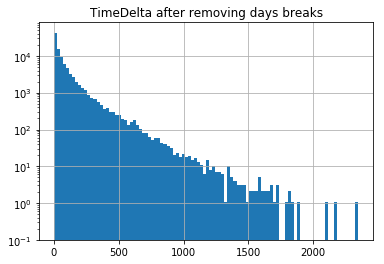

In [16]:
fig, ax = plt.subplots()
df_merged.TimeDelta.hist(ax=ax,bins=100, bottom=0.1)

# series.hist( bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_title('TimeDelta after removing days breaks')
plt.show()

# Prediction

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, model_selection, svm
import numpy as np

In [ ]:
df=df_group_by_day_list[0]

data_size=len(df)

In [ ]:
df.tail()

In [ ]:
df[['Close','TimeDelta','y']]

In [ ]:
X=[]
X.append(2)
X.append(3)
X


In [ ]:
LEARN_SAMPLE_SIZE=5

In [ ]:
for i in range(1,LEARN_SAMPLE_SIZE):
    df['Close_'+str(i)]=df.Close.shift(i)
    df['TimeDelta'+str(i)]=df.TimeDelta.shift(i)

In [ ]:
df.tail()

In [ ]:
# X = np.array(df.drop(['PredictionPrice',"PredictionTime"], 1))
X = np.array(df[['Close','TimeDelta']])


In [ ]:
# y = np.array(df[['PredictionPrice',"PredictionTime"]])
y =  np.array(df.y)

In [ ]:
# Create the Scaler object
scaler = preprocessing.StandardScaler()

In [ ]:
normalized_X = preprocessing.scale(X)

In [ ]:
normalized_y = preprocessing.scale(y)

In [ ]:
print(normalized_y.shape,normalized_X.shape)

In [ ]:
normalized_X

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(normalized_X, normalized_y, test_size = 0.2, shuffle=False)

In [ ]:
X_train,y_train

In [ ]:
# Training
clf = LinearRegression()
clf.fit(X_train,y_train)
# Testing
confidence = clf.score(X_test, y_test)
print("confidence: ", confidence)

In [ ]:
forecast_prediction = clf.predict(X_forecast)
print(forecast_prediction)

In [ ]:
a=X_test[:-5]
print(a)
print(y_test[:-5])

In [ ]:
clf.predict(a)